In [1]:
import matplotlib.pyplot as plt
from matplotlib  import rc
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import numpy as np

In [2]:
# Create a Census object with an API key
c = Census("a82acbcf878654f6da6b3139274b90ff160b8120")

# Get census data for Arizona at the tract level for additional fields in 2020
az_census = c.acs5.state_county_tract(fields=('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E', 'B02001_002E', 'B06011_001E'),
                                      state_fips=states.AZ.fips,
                                      county_fips="*",
                                      tract="*",
                                      year=2020)

# Convert census data to a Pandas DataFrame
az_df = pd.DataFrame(az_census)

# Get the Arizona tract shapefile
az_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_04_tract.zip")

# Convert the shapefile to the UTM Zone 17N coordinate system
az_tract = az_tract.to_crs(epsg=32617)

# Combine the census data with the shapefile using the GEOID column
az_df["GEOID"] = az_df["state"] + az_df["county"] + az_df["tract"]
az_df = az_df.drop(columns=["state", "county"])
az_merge = az_tract.merge(az_df, on="GEOID")

# Select columns for poverty and minority analysis
az_minority_tract = az_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E", "B02001_002E",'B06011_001E']]

# Aggregate data to the county level

In [6]:
# az_minority_tract

,STATEFP,COUNTYFP,TRACTCE,GEOID,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,B02001_002E,B06011_001E
0,04,015,950500,04015950500,"POLYGON ((-2605753.221 4497432.366, -2605733.2...",1589.0,97.0,248.0,1601.0,1455.0,17085.0
1,04,015,954900,04015954900,"POLYGON ((-2561412.583 4449714.181, -2561223.1...",3660.0,163.0,338.0,3662.0,3460.0,26371.0
2,04,015,951800,04015951800,"POLYGON ((-2620096.770 4449251.952, -2620077.4...",3629.0,182.0,456.0,3629.0,2589.0,16514.0
3,04,015,952400,04015952400,"POLYGON ((-2622343.321 4399330.830, -2622188.9...",2747.0,15.0,139.0,2747.0,2629.0,25766.0
4,04,027,012100,04027012100,"POLYGON ((-2693911.900 4201040.592, -2692586.4...",875.0,54.0,119.0,933.0,653.0,26122.0
...,...,...,...,...,...,...,...,...,...,...,...
1760,04,019,003707,04019003707,"POLYGON ((-2379163.068 3982375.362, -2379147.7...",3277.0,248.0,665.0,3277.0,1945.0,20729.0
1761,04,019,004067,04019004067,"POLYGON ((-2366025.292 3988570.724, -2365951.0...",2856.0,213.0,97.0,2892.0,2200.0,27071.0
1762,04,019,003303,04019003303,"POLYGON ((-2368023.152 3988276.401, -2368018.3...",3684.0,441.0,276.0,3725.0,2785.0,25739.0
1763,04,019,003706,04019003706,"POLYGON ((-2378901.301 3983239.291, -2378884.7...",6538.0,1025.0,754.0,6539.0,4345.0,23854.0


In [9]:
az_minority_county = az_minority_tract #.dissolve(by='TRACTCE', aggfunc='sum')

In [10]:
# Calculate the percentage of the white population in each county
az_minority_county["White_Rate"] = (az_minority_county["B02001_002E"]) / az_minority_county["B01003_001E"] * 100

az_minority_county['majority-minority'] = az_minority_county["White_Rate"] < 50

az_minority_county['below_p10_income'] = az_minority_county["B06011_001E"] < az_minority_county["B06011_001E"].quantile(0.1)

C:\Users\DonsLaptop\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\DonsLaptop\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\DonsLaptop\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [11]:
def red_line_map(df,shading_var:str,redline_var:str,optional_title= None,option_zoom_params=None):
    fig, ax = plt.subplots(1, 1, figsize = (20, 10))

    # Plot data
    # Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
    df.plot(column = shading_var,
                           ax = ax,
                           cmap = "Greens",
                           legend = True)

    # add the the majority minority tract lines in red
    query = f'`{redline_var}`'
    df.query(query).boundary.plot(color='red',ax=ax, linewidth=2)

    # add the other tract lines in grey
    query = f'`{redline_var}` == False'    
    df.query(query).boundary.plot(color='gainsboro',ax=ax, linewidth=.2)

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    plt.title(f'{shading_var} in AZ \n Red outlines are based on {redline_var}', fontdict = {'fontsize': 15})

    # optionally, zoom in
    if option_zoom_params:
        ax.set_xlim(option_zoom_params['x'])
        ax.set_ylim(option_zoom_params['y'])

# Some useful plots

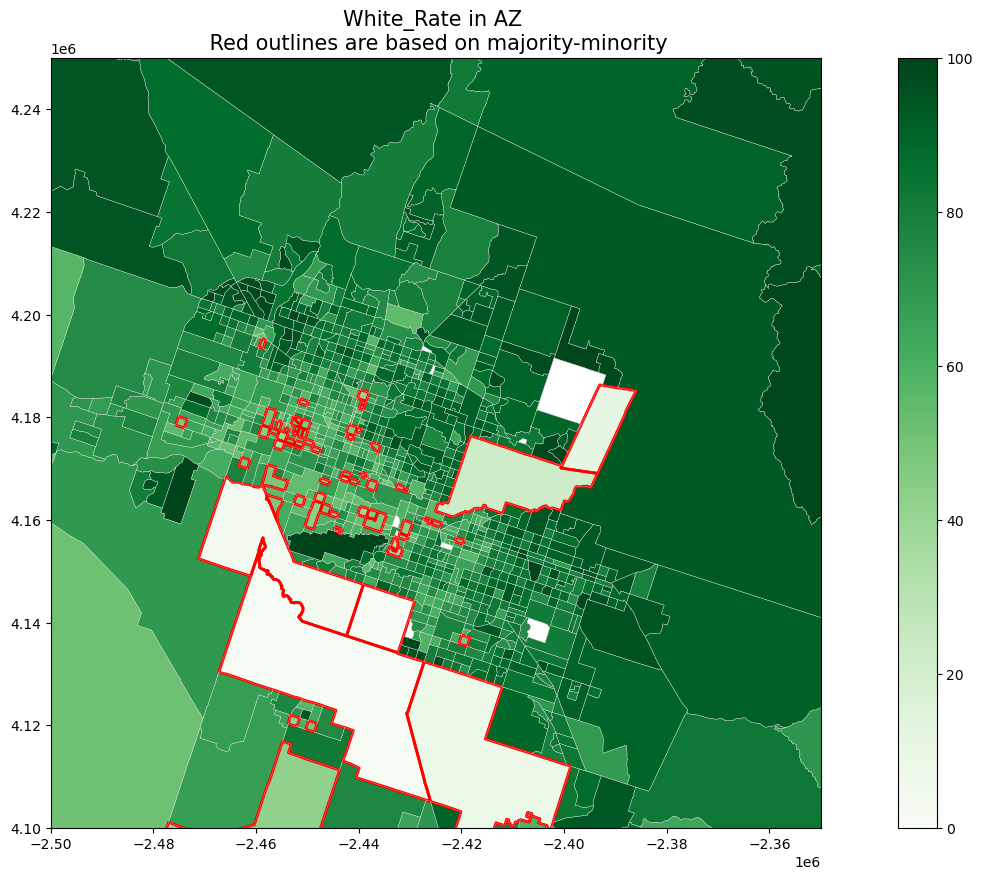

In [12]:
phx_zoom = {'x': [-2.5e6,-2.35e6], 'y' : [4.1e6,4.25e6]}

red_line_map(az_minority_county,'White_Rate','majority-minority',option_zoom_params=phx_zoom)